In [71]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dset
import matplotlib.pylab as plt
from torch.utils.data import DataLoader
import numpy as np
import time as timer
import random

import PIL
from PIL import Image

In [72]:
IMAGE_SIZE = 28

composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), PIL.Image.LANCZOS),transforms.Grayscale(), transforms.ToTensor()])
tesT_DIR = './test_images/' 

In [73]:
test_dataset = dset.ImageFolder(root=tesT_DIR, transform=composed)
dataloader = DataLoader(test_dataset,batch_size=10, shuffle=True)

In [74]:
for images, labels in dataloader:
    # Your training loop here
    print(images.shape, labels)

torch.Size([10, 1, 28, 28]) tensor([7, 2, 5, 4, 0, 2, 9, 6, 2, 8])
torch.Size([10, 1, 28, 28]) tensor([4, 1, 5, 3, 3, 8, 8, 0, 3, 8])
torch.Size([10, 1, 28, 28]) tensor([7, 9, 7, 6, 9, 5, 4, 0, 4, 1])
torch.Size([10, 1, 28, 28]) tensor([8, 5, 5, 3, 9, 6, 7, 1, 2, 6])
torch.Size([10, 1, 28, 28]) tensor([3, 1, 0, 7, 6, 2, 0, 9, 4, 1])


In [75]:
class CNN_batch(nn.Module):

    # Contructor
    def __init__(self, out_1=28, out_2=56, out_3=100, number_of_classes=10):
        super(CNN_batch, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)

        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.maxpool2=nn.MaxPool2d(kernel_size=2)

        self.cnn3 = nn.Conv2d(in_channels=out_2, out_channels=out_3, kernel_size=5, stride=1, padding=2)
        self.conv3_bn = nn.BatchNorm2d(out_3)

        self.maxpool3=nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(out_3*9, number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(10)

    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)

        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)

        x = self.cnn3(x)
        x = self.conv3_bn(x)
        x = torch.relu(x)
        x = self.maxpool3(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn_fc1(x)
        return x

In [76]:
CPU_model = CNN_batch()
GPU_model = CNN_batch()

CPU_model.load_state_dict(torch.load('CNN_model_CPU.pt'))

GPU_model.load_state_dict(torch.load('CNN_model_GPU.pt'))

<All keys matched successfully>

In [77]:
cpu_acc = 0
gpu_acc = 0 
correct = 0
image_count = 50

for images, labels in dataloader:
    # Your training loop here
    z = CPU_model(images)
    _, yhat = torch.max(z.data, 1)  # Get the predictions
    correct += (yhat == labels).sum().item()
    
cpu_acc = correct / image_count
correct = 0

for images, labels in dataloader:
    # Your training loop here
    z = GPU_model(images)
    _, yhat = torch.max(z.data, 1)  # Get the predictions
    correct += (yhat == labels).sum().item()

gpu_acc = correct / image_count

In [78]:
cpu_acc

0.18

In [79]:
gpu_acc

0.12

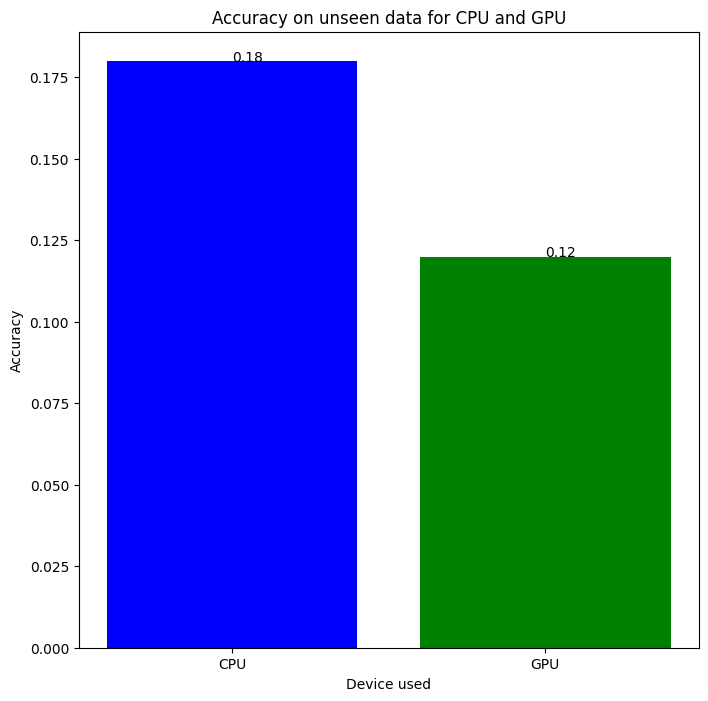

In [80]:
times = [cpu_acc, gpu_acc]
labels = ['CPU', 'GPU']
colors = ['blue', 'green']

plt.figure(figsize=(8, 8))
plt.bar(labels, times, color=colors)
plt.title('Accuracy on unseen data for CPU and GPU')
plt.xlabel('Device used')
plt.ylabel('Accuracy')
for i,j in enumerate(times):
    plt.text(i,j,np.round(j,4))
plt.show()